# Project brief

The risk of floods has naturally increased due to climate change variability, rapid urbanization, and rapidly expanding spatial development. This hazard to human lives and the global economy has become quite severe. The study focused on forecasting flood susceptibility, as well as enhancing the management of potential pluvial flooding risk through the application of machine learning techniques. The dataset for this study was gathered from the Ibadan Metropolis in Oyo state, South West Nigeria, by the Copernicus Climate Data Store and the United States Geological Survey (USGS) using the ArcGIS software. A total of 144,401 records and 8 conditioning variables out of 53 were gathered. Various features including drainage, slope, coordinates (X and Y), curvature, rainfall, flow accumulation, aspect, and topographic wetness index were utilized to predict flooding susceptibilities in this study, using two Machine Learning algorithms: LogisticRegression and RandomForest.

# **1. Load relevant libraries**

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Data preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# tqdm
from tqdm.notebook import tqdm_notebook

# warnings
import warnings
warnings.filterwarnings('ignore')

# **2. Load data**

In [2]:
data = pd.read_excel("Pluvial_Flood_Dataset.xlsx")

data.head()

,X,Y,Slope,Curvature,Aspect,TWI,FA,Drainage,Rainfall,SUSCEP
0,3.909444,7.443056,46.686142,-3.888000e+09,45.000000,-3.250368,147.0,228.8528,101.515616,Very_High
1,3.908611,7.442778,52.151768,1.296000e+09,60.945396,-4.313832,61.0,229.6781,80.409863,Very_High
2,3.908889,7.442778,66.484085,0.000000e+00,67.619865,-8.327622,1.0,230.5920,78.986849,Very_High
3,3.909167,7.442778,58.007183,-2.592000e+09,38.659809,-4.707937,51.0,235.4210,81.953151,Very_High
4,3.909444,7.442778,60.503792,-1.296000e+09,351.869904,-5.985817,15.0,234.4346,85.866027,Very_High


In [3]:
data.shape

(144401, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144401 entries, 0 to 144400
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   X           144401 non-null  float64
 1   Y           144401 non-null  float64
 2   Slope       144119 non-null  float64
 3   Curvature   144401 non-null  float64
 4   Aspect      144401 non-null  float64
 5   TWI         144401 non-null  float64
 6   FA          144401 non-null  float64
 7   Drainage    144401 non-null  float64
 8   Rainfall    144401 non-null  float64
 9   SUSCEP      144401 non-null  object 
dtypes: float64(9), object(1)
memory usage: 11.0+ MB


# **3. EDA**

In [5]:
#check for duplicate rows

data.duplicated().sum()

0

In [6]:
#check for missing values

df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values.style.background_gradient(cmap = 'Spectral')

,count,%
Slope,282,0.195290
X,0,0.000000
Y,0,0.000000
Curvature,0,0.000000
Aspect,0,0.000000
TWI,0,0.000000
FA,0,0.000000
Drainage,0,0.000000
Rainfall,0,0.000000
SUSCEP,0,0.000000


In [7]:
numerical_features = data.select_dtypes(include = ['int', 'float']).columns.to_list()

print(f'Total Numerical features = {len(numerical_features)}')

Total Numerical features = 9


In [8]:
categorical_feature = data.select_dtypes(include = ['object', 'category']).columns.to_list()

print(f'Total Categorical feature = {len(categorical_feature)}')

Total Categorical feature = 1


## **3.1 Univariate Analysis**

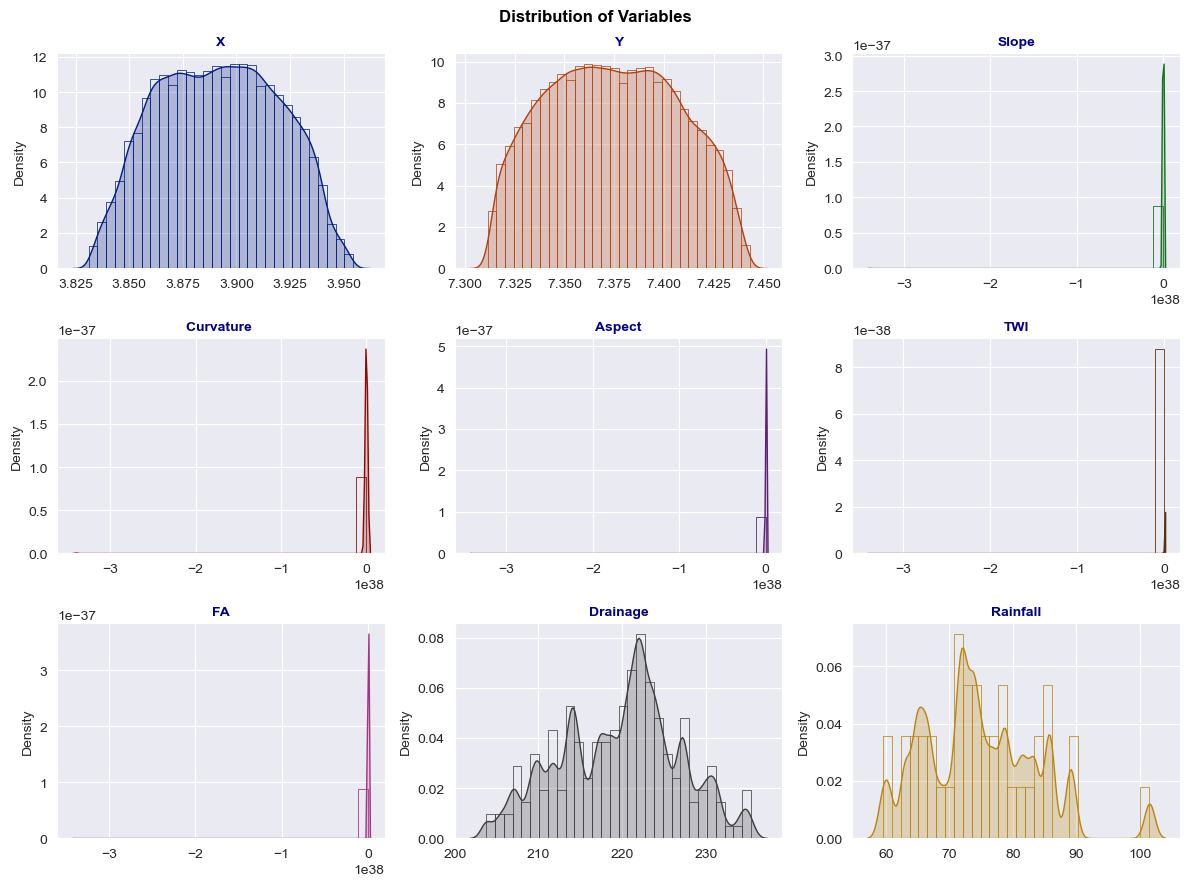

In [9]:
sns.set_style("darkgrid")

colors = sns.color_palette(palette = 'dark', n_colors = len(numerical_features))

fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 9))
axs = axs.flat

for i,num_feat in enumerate(numerical_features):
    sns.kdeplot(data, x = num_feat, fill = True, color = colors[i], ax = axs[i])
    sns.histplot(data, x = num_feat,bins = 30, stat = 'density', fill = False, color = colors[i], ax = axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(num_feat, fontsize = 10, fontweight = 'bold', color = 'darkblue')

fig.suptitle("Distribution of Variables", fontsize = 12, fontweight = 'bold', color = 'black')
fig.tight_layout()
fig.show()

In [10]:
data[numerical_features].describe()

,X,Y,Slope,Curvature,Aspect,TWI,FA,Drainage,Rainfall
count,144401.000000,144401.000000,1.441190e+05,1.444010e+05,1.444010e+05,1.444010e+05,1.444010e+05,144401.000000,144401.000000
mean,3.891534,7.374551,-2.502788e+35,-8.342043e+35,-1.673122e+35,-2.120858e+34,-2.120858e+35,219.714542,74.786932
std,0.027887,0.032459,9.225150e+36,1.682769e+37,7.543591e+36,2.686356e+36,8.492619e+36,7.057921,8.891617
min,3.831111,7.311389,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,203.729300,59.541096
25%,3.868889,7.348333,5.105756e+01,-2.592000e+09,1.013099e+02,-8.654586e+00,0.000000e+00,214.286900,68.140822
50%,3.891667,7.374167,6.198023e+01,0.000000e+00,1.894623e+02,-8.006991e+00,1.000000e+00,220.631300,73.873425
75%,3.913611,7.400278,6.916712e+01,2.592000e+09,2.700000e+02,-6.709276e+00,6.000000e+00,224.191400,81.329315
max,3.954444,7.443056,8.657541e+01,3.888000e+10,3.591449e+02,1.168344e+01,4.579360e+05,235.421000,101.515616


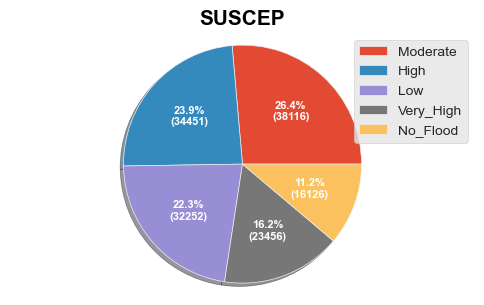

In [11]:
plt.style.use('ggplot')

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(figsize = (6,3.4))

df_class = data['SUSCEP'].value_counts().to_frame()
labels = df_class.index.to_list()
values = df_class.iloc[:,0].to_list()
ax.pie(x = values, labels = labels, autopct=autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':8, 'fontweight':'bold'})
ax.legend(labels, loc = 'best')
ax.set_title('SUSCEP', fontsize = 15, fontweight = "bold", color = "black")
ax.axis('equal')
fig.show()

## **3.2 Bivariate Analysis**

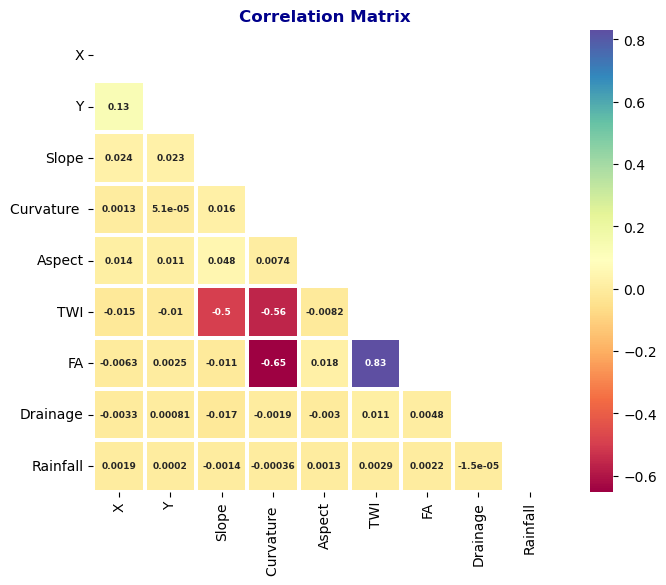

In [12]:
plt.style.use('default')
corr_matrix_spearman = data[numerical_features].corr(method = 'spearman')
mask = np.triu(np.ones_like(corr_matrix_spearman, dtype = bool))

fig,ax = plt.subplots(figsize = (9, 6))
sns.heatmap(corr_matrix_spearman, 
            cmap = 'Spectral', 
            annot = True, 
            annot_kws = {'fontsize':6.5, 'fontweight':'bold'}, 
            linewidths = 1.5, 
            square = True, 
            mask = mask,
            ax = ax)
ax.set_title("Correlation Matrix", fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.show()

# **4. Preprocessing**

In [13]:
#Data splitting

X = data.drop('SUSCEP', axis = 1)
y = data['SUSCEP']

In [14]:
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)

In [15]:
#Encoding categorical variables

LABELS = ['No_Flood', 'Low', 'Moderate', 'High', 'Very_High']
label2id = dict(zip(LABELS, range(len(LABELS))))
label2id

{'No_Flood': 0, 'Low': 1, 'Moderate': 2, 'High': 3, 'Very_High': 4}

In [16]:
y_train = y_train.map(label2id)
y_test = y_test.map(label2id)

In [17]:
y_train.value_counts()

SUSCEP
2    26665
3    24144
1    22541
4    16357
0    11373
Name: count, dtype: int64

In [18]:
y_test.value_counts()

SUSCEP
2    11451
3    10307
1     9711
4     7099
0     4753
Name: count, dtype: int64

In [19]:
X_train.isnull().sum()

X               0
Y               0
Slope         206
Curvature       0
Aspect          0
TWI             0
FA              0
Drainage        0
Rainfall        0
dtype: int64

In [20]:
X_test.isnull().sum()

X              0
Y              0
Slope         76
Curvature      0
Aspect         0
TWI            0
FA             0
Drainage       0
Rainfall       0
dtype: int64

- **Imputation**

In [21]:
# Replace null cells with median values

imputer = SimpleImputer(strategy = 'median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

- **Standardize our variables for our base model**

In [22]:
# Standardize 'features' dataset: this is important because of the variance within the dataset

# -instantiate scaler
scaler = StandardScaler()

# -fit (pass or fit the training dataset into the scaler)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# **5. Models**

In [23]:
# We define our models, and choose the model that best performs.

# -instantiate algorithms
RF = RandomForestClassifier(random_state = 42, n_jobs = -1)
LR = LogisticRegression(multi_class = 'multinomial', max_iter = 1000, random_state = 42, n_jobs = -1)

MODELS = [RF, LR]

In [24]:
# Training
accuracy_train = {}
accuracy_test = {}
#create a function to train, predict, and check accuracy
for model in tqdm_notebook(MODELS):
    name = type(model).__name__
    
    # -fit (pass or fit the scaled dataset into the algorithm)
    model.fit(X_train_scaled, y_train)
    
    # -predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # -check accuracy
    accuracy_train[name] = balanced_accuracy_score(y_train, y_pred_train)
    accuracy_test[name] = balanced_accuracy_score(y_test, y_pred_test)
    print(f'* {name} finished.')

  0%|          | 0/2 [00:00<?, ?it/s]

* RandomForestClassifier finished.
* LogisticRegression finished.


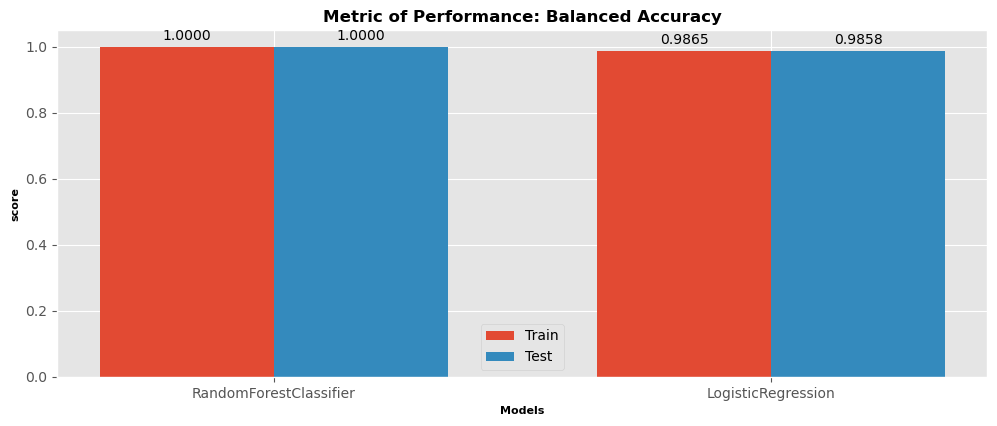

In [25]:
plt.style.use('ggplot')
metric_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index')
metric_train = metric_train.rename(columns = {0:'Train'})

metric_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index')
metric_test = metric_test.rename(columns = {0:'Test'})

fig,ax = plt.subplots(figsize = (12,4.5))

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:,0].to_list()
values_test = metric_test.iloc[:,0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x = x - width/2, height = values_train, width = width, label = 'Train')
rects2 = ax.bar(x = x + width/2, height = values_test, width = width, label = 'Test')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}', 
                    xy = (rect.get_x() + rect.get_width()/2, height), 
                    xytext = (0,3), 
                    textcoords = "offset points", 
                    ha = "center", 
                    va = "bottom")
        
autolabel(rects1)
autolabel(rects2)
ax.legend()
ax.set_title("Metric of Performance: Balanced Accuracy", fontsize = 12, fontweight = "bold", color = "black")
ax.set_ylabel("score", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xlabel("Models", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()

In general, both models gave good performances in the training and the test sets. But the  **RandomForestClassifier**, gave a much better performance and outperformed the Logistic Regression model. Hence it will be chosen to calculate some additional metrics.

# **6. Evaluation Metrics**

In [26]:
# Predictions 
y_pred_train_final = RF.predict(X_train_scaled)
y_pred_test_final = RF.predict(X_test_scaled)

- **Classification Report**

In [27]:
#Classification Report Test
print(classification_report(y_test, y_pred_test_final, target_names = LABELS))

print('\n')

#Classification Report Test
print(classification_report(y_test, y_pred_test_final, target_names = LABELS))

              precision    recall  f1-score   support

    No_Flood       1.00      1.00      1.00      4753
         Low       1.00      1.00      1.00      9711
    Moderate       1.00      1.00      1.00     11451
        High       1.00      1.00      1.00     10307
   Very_High       1.00      1.00      1.00      7099

    accuracy                           1.00     43321
   macro avg       1.00      1.00      1.00     43321
weighted avg       1.00      1.00      1.00     43321



              precision    recall  f1-score   support

    No_Flood       1.00      1.00      1.00      4753
         Low       1.00      1.00      1.00      9711
    Moderate       1.00      1.00      1.00     11451
        High       1.00      1.00      1.00     10307
   Very_High       1.00      1.00      1.00      7099

    accuracy                           1.00     43321
   macro avg       1.00      1.00      1.00     43321
weighted avg       1.00      1.00      1.00     43321



- **Confusion Matrix**

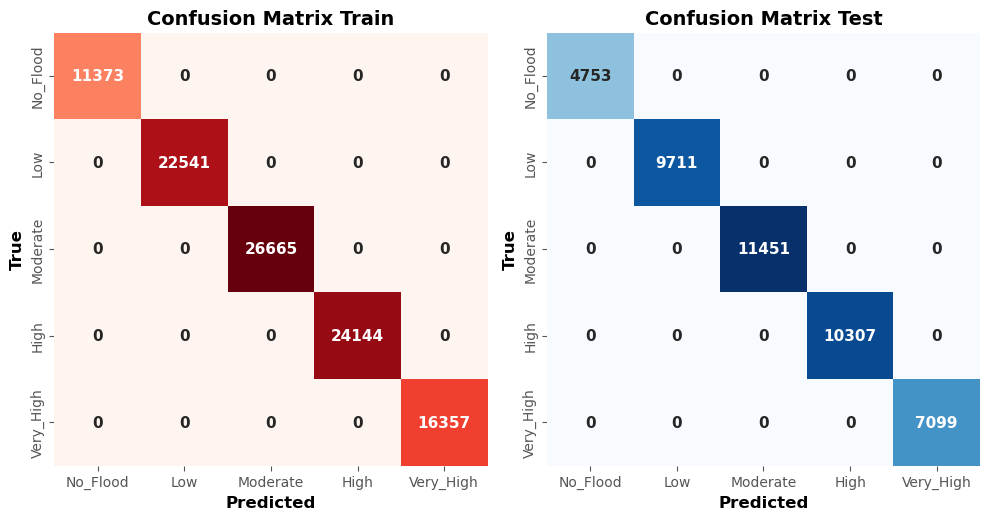

In [28]:
cf_mx_train = confusion_matrix(y_train, y_pred_train_final)
cf_mx_test = confusion_matrix(y_test, y_pred_test_final)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', xticklabels = LABELS, yticklabels = LABELS, cbar = False, square = True, ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', xticklabels = LABELS, yticklabels = LABELS, cbar = False, square = True, ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_title('Confusion Matrix Train', fontsize = 14, fontweight = "bold", color = "black")
axs[1].set_title('Confusion Matrix Test', fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

# **7. Conclusion**

This study focused on forecasting flood susceptibility in regions within Ibadan Metropolis
in Oyo state, South West Nigeria, using LogisticRegression and RandomForestClassifier
models. Various features including drainage, slope, coordinates (X and Y), curvature,
rainfall, flow accumulation, aspect, and topographic wetness index were utilized to
predict flooding susceptibilities in this study.
The Logistic Regression model had a training accuracy of 98.7%, and a test accuracy of
98.6%, while the Random Forest Classifier had a training accuracy of 100%, and a test
accuracy of 100%. Both models gave good performances in the training and test sets, but
the Random Forest Classifier outperformed the Logistic Regression model, hence it was
chosen as the optimal model.